In [36]:
import time

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

![title](plots/index.png)

# Periodic Autoencoder

What's a periodic Autoencoder? Well, it is a normal autoencoder, but the latent space is not only compact but periodical, meaning that there is no beginning nor end and you can go round and round forever...

#### Contents
* [1. Introduction](#Introduction)
* [2. Data Exploration](#DataExploration)
* [3. Model Definition and Training](#Model)
* [4. Analysis](#Analysis)
* [5. Conclusion](#Conclusion)

### 1. Introduction<a name="Introduction"></a>
An autoencoder constist of an encoder function that transforms data from some space $\mathcal X \subset \mathbf R^P$ to a lower dimensional latent space $\mathcal Z \subset \mathbf R^M$: $f_{\mathrm{enc}}: \mathcal X \rightarrow \mathbf Z$. The decoder function has the task of undoing this operation (as best as possible): $f_{\mathrm{dec}}: \mathcal Z \rightarrow \mathcal X$. In general, $M<P$ and therefore the encoder operation is not invertible. The autoencoder optimizes a maximum likelihood criterium of the form (Loss function):
$$L=\sum_{i=1}^N \left\|x_i-f_\mathrm{dec}\circ f_\mathrm{enc}(x_i)\right\|^2$$
where $x_i\in\mathcal X, i=1\ldots N$ is some data set.

The periodic autoencoder should have a closed and periodic topology, namely $\mathcal Z=\mathbf S^1$ is the one-dimensional circle.
We will achieve this by simply adding special activation functions in the middle of the autoencoder, using the $z=\mathrm{arctan2}(x,y)$ function to get to lowest dimension and then "periodicising" the output by calculating the sine and cosine of this number. The subsequent neural network than transforms this data back into $\mathcal X$.

Both encoder and decoder functions are given by neural networks and we will use the tensorflow framework to implement those as depicted below.

In [2]:
def build_autoencoder(n_features, layers_encoder=None, layers_decoder=None,
                      activations=tf.nn.tanh):
    """
    Builds a periodical autoencoder with one latent dimension
    :param n_features: int, data input dimension
    :param layers_encoder: list of intermediary representations, can be empty
    :param layers_decoder: list of intermediary representations, can be empty
    :param activations: tf pointwise activation function
    :return: dictionary with a lot of tensors, see return statement
    """
    
    layers_encoder = [] if layers_encoder is None else layers_encoder
    layers_decoder = [] if layers_decoder is None else layers_decoder
    
    # input nodes
    x = tf.placeholder(tf.float32, shape=[None, n_features], name="x")
    
    # encoder neural net
    x_ = tf.contrib.layers.stack(x, tf.contrib.layers.fully_connected, layers_encoder,
                                activation_fn=activations, scope="encoder")
    
    # latent representation
    z = tf.contrib.layers.fully_connected(x_, 2, None)
    
    # periodicization
    phi = tf.reshape(tf.atan2(z[:,1], z[:,0]), [-1, 1], name='phi')
    # for manual angle input to reconstruct
    phi_manual = tf.placeholder(tf.float32, shape=[None, 1], name="phi_manual")
    
    # periodicization
    freq = tf.constant([[1.,1.]])
    phase = tf.constant([np.pi/2,0.])
    circ = tf.sin(tf.matmul(phi, freq) + phase, name="circ")
    circ_manual = tf.sin(tf.matmul(phi_manual, freq) + phase, name="circ_manual")
    
    # decoder neural net
    x_ = tf.contrib.layers.stack(circ, tf.contrib.layers.fully_connected, layers_encoder,
                                activation_fn=activations, scope="decoder")
    x_manual = tf.contrib.layers.stack(circ_manual, tf.contrib.layers.fully_connected,
                                       layers_encoder, activation_fn=activations,
                                       reuse=True, scope="decoder")
    
    # output representation
    x_hat = tf.identity(tf.contrib.layers.fully_connected(x_, n_features, None, scope="final"),
                        name="x_hat")
    x_hat_manual = tf.identity(tf.contrib.layers.fully_connected(
                               x_manual, n_features, None, scope="final", reuse=True),
                               name="x_hat_manual")
    
    
    distances = tf.square(x - x_hat, name="distances")
    # reconstruction error
    loss = tf.reduce_mean(distances, name="loss")
    
    print("Autoencoder network layers (inclusive in- and output neurons):  {0}".format(
        [n_features] + layers_encoder + [2, 1] + layers_decoder + [n_features]))
    model = {
        "loss": loss,
        "distances": distances,
        "x_hat": x_hat,
        "x_hat_manual": x_hat_manual,
        "x": x,
        "phi": phi,
        "phi_manual": phi_manual,
    }
    return model

Below function is used for batch processing during training

In [3]:
def random_batch_generator(data, batch_size, shuffle=True):
    """
    :param data: array of rank at least one [data_size, ...]
    :param batch_size: int, specifies size of first dimension of output batch, eg how many samples
    :param shuffle: bool, default=True
    :yields batch: random batch of shape [batch_size, ...]
    """
    n = len(data)
    batch_size = min(n, max(1, batch_size))
    if batch_size == n:
        shuffle = False
    
    indices = np.arange(n)
    if shuffle:
        np.random.shuffle(indices)
    i = 0
    while True:
        
        batch = data[indices[i:i + batch_size]]
        i += batch_size
        # consider the case where there is not enough data left to accomodate
        l = len(batch)
        if l == batch_size:
            if i == n:
                i = 0
        else:
            if shuffle:
                np.random.shuffle(indices)
            batch = np.append(batch, data[indices[:batch_size - l]], axis=0)
            i = batch_size - l
        yield batch

### 2. Data exploration<a name="DataExploration"></a>

Load and scatter the 2-dimensional data set

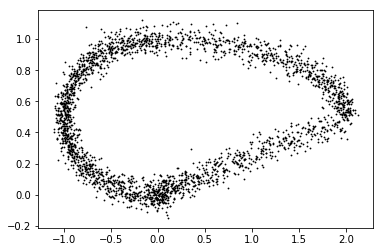

In [4]:
data1_train = np.loadtxt("data/main2_x1-y2_train.csv", delimiter=";", skiprows=1)[:,[2, 3]]
data1_test = np.loadtxt("data/main2_x1-y2_test.csv", delimiter=";", skiprows=1)[:,[3, 4]]

_ = plt.plot(data1_train[:,0], data1_train[:,1], 'o', ms=.8, color="black")

The data is artificially data generated to be on a periodical path, including some gaussian noise term. The 3 sections are (starting from the bottom):
* Linear increase, going right
* Square root increase, going left
* Circular path back to the start

### 3. Model definition and Training<a name="Model"></a>

We now define some hyperparameter for the autoencoder determining the complexity of the model and training procedure:

In [5]:
layers = [128,128]
n_train = 5000
batch_size = 128
learning_rate = 0.001
activations = tf.nn.tanh

test_step = n_train//100

Prepare validation data and batch processing

In [6]:
data1_valid = data1_test[:2000]

n_samples, n_features = data1_train.shape
batch_generator = random_batch_generator(data1_train, batch_size)
print("Train data: {0}".format(data1_train.shape))
print("Valid data: {0}".format(data1_valid.shape))

Train data: (2560, 2)
Valid data: (2000, 2)


Initialize the autoencoder, training op, the session and all variables

In [7]:
model = build_autoencoder(n_features, layers_encoder=layers,
                                    layers_decoder=layers, activations=activations)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(model["loss"])

sess = tf.Session()
sess.as_default()
init = tf.global_variables_initializer()
sess.run(init)

Autoencoder network layers (inclusive in- and output neurons):  [2, 128, 128, 2, 1, 128, 128, 2]


Train the autoencoder

Step 5000: valid=0.0025617  train=0.0029468


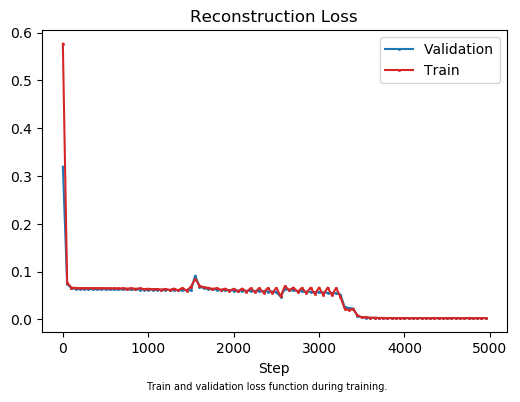

In [8]:
train_loss_, i = 0, 0
valid_loss, train_loss, steps = [], [], []
while i < n_train:
    batch = next(batch_generator)
    train_loss_, _ = sess.run([model["loss"], train_op], feed_dict={model["x"]: batch})
    if (i % test_step == 0):
        valid_loss_ = sess.run(model["loss"], feed_dict={model["x"]: data1_valid})
        valid_loss.append(valid_loss_)
        steps.append(i)
        train_loss.append(train_loss_)
        # print("Step {0}: valid={1:.5g}  train={2:.5g}".format(i, valid_loss_, train_loss_))
          
    i += 1
plt.close("all")
fig, ax = plt.subplots(dpi=100)
ax.set_title("Reconstruction Loss")
ax.set_xlabel("Step")
ax.plot(steps, valid_loss, '-s', ms=1, color="tab:blue", label="Validation")
ax.plot(steps, train_loss, '-s', ms=1, color="tab:red", label="Train")
ax.legend()
_ = plt.figtext(0.5, -0.02, "Train and validation loss function during training.",
                wrap=True, horizontalalignment='center', fontsize=7)
valid_loss_ = sess.run(model["loss"], feed_dict={model["x"]: data1_valid})
print("Step {0}: valid={1:.5g}  train={2:.5g}".format(i, valid_loss_, train_loss_))

### 4. Analysis<a name="Analysis"></a>

We want now to try and visualize the learned latent representation of the 1D periodic autoencoder. To do this, we will reconstruct the whole latent space $\mathcal Z=[0,2\pi]$ and plot it in original data space.

Because we are only working with a 2-dimensional dataset, we will also encode and reconstruct the whole section of relevant $\mathbf R^2$ subspace that is populated by data in a square section (on a grid).

By comparison with the original grid, we can evaluate which sections are well represented in the autoencoder and which are not.

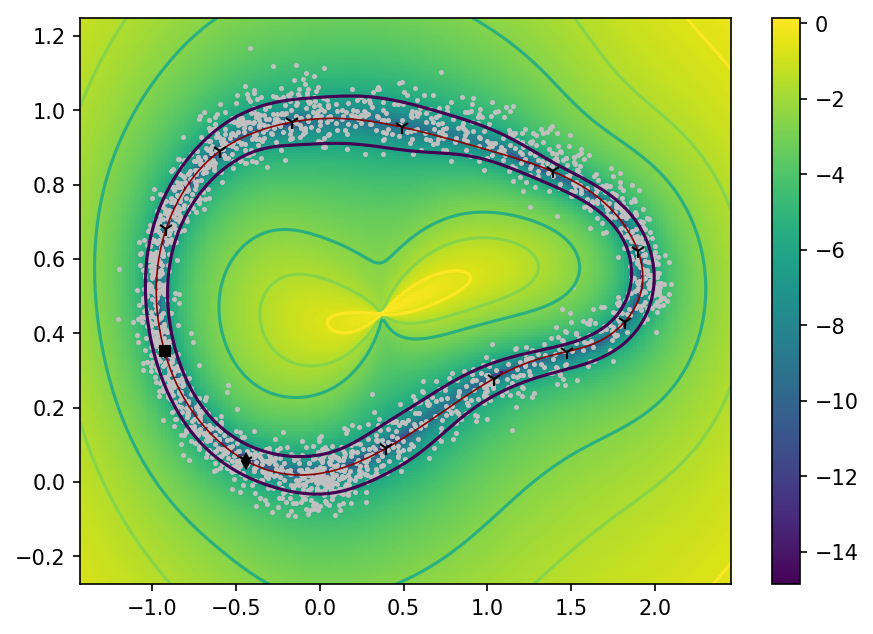

In [35]:
latent_space = np.linspace(0, 2*np.pi, 360).reshape((-1, 1))
latent_space_decoded = sess.run("x_hat_manual:0",
                                feed_dict={"phi_manual:0": latent_space})
data1_valid_decoded, data1_valid_distances = sess.run(["x_hat:0", "distances:0"],
                                                      feed_dict={"x:0": data1_valid})
data1_valid_distances = np.mean(data1_valid_distances, axis=1)

n_latice = 200
delta_x = np.amax(data1_train, axis=0) - np.amin(data1_train, axis=0)
x_min = np.amin(data1_train, axis=0) - 0.1*delta_x
x_max = np.amax(data1_train, axis=0) + 0.1*delta_x
x_space = [np.linspace(x_min_, x_max_, n_latice) for x_min_, x_max_ in zip(x_min, x_max)]
grid = np.stack(np.meshgrid(x_space[0], x_space[1])).reshape((2, -1)).T

grid_decoded, grid_distances = sess.run([model["phi"], model["distances"]], 
                                       feed_dict={model["x"]: grid})
grid_distances = np.mean(grid_distances, axis=1)

grid_error = np.log(grid_distances).reshape((n_latice, n_latice))
contour_vals = list(np.log(np.percentile(data1_valid_distances, [68.2689492, 100])))
contour_vals += [contour_vals[-1]+1, contour_vals[-1]+2]

fig = plt.figure(figsize=(7,5), dpi=150)
canvas = plt.imshow(grid_error[::-1], interpolation=None,
                    extent=(x_min[0], x_max[0], x_min[1], x_max[1]), aspect='auto')

plt.scatter(data1_valid[:, 0], data1_valid[:, 1], s=2, color="silver")
plt.plot(latent_space_decoded[:, 0], latent_space_decoded[:, 1], lw=.8, color="darkred")
plt.plot(latent_space_decoded[::30, 0], latent_space_decoded[::30, 1], '1', ms=7, color="black")
plt.plot(latent_space_decoded[0, 0], latent_space_decoded[0, 1], 's', ms=5, color="black")
plt.plot(latent_space_decoded[30, 0], latent_space_decoded[30, 1], 'd', ms=5, color="black")
plt.contour(x_space[0], x_space[1], grid_error, contour_vals)

_ = plt.colorbar(canvas)


The red curve shows the embedding of the latent space. In order to estimate the scale, the triangular marker are evenly spaced in the angular regime (each 30°). The square marker marks the 0°, while the diamond marker shows the direction (at 30°).

The colors show in a logarithmic scale the distance for each point to the latent space.
The first contour is the 68.3 percentile (1 gaussian sigma). 68.3% of all data (silver points) are to be found here. The next contour includes all of the data, while the rest is just for visual purposes.

Last we can plot the histogram of how data is distributed in the latent space. This gives us deeper insights on the density of the data in a more meaningfull representation than the original data space.

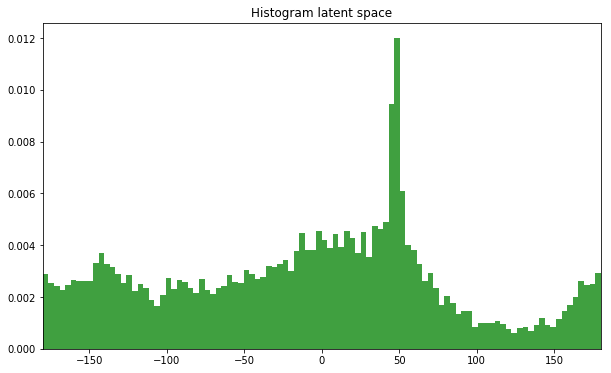

In [33]:
data1_test_decoded, data1_test_latent = sess.run(["x_hat:0", "phi:0"],
                             feed_dict={"x:0": data1_test})

fig = plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(data1_test_latent[:, 0]/2/np.pi*360, bins=100,
                            normed=1, facecolor='green', alpha=.75)
plt.gca().set_title("Histogram latent space")
_ = plt.xlim((-180, 180))

### 5. Conclusion<a name="Conclusion"></a>

In this notebook we showed how to implement a simple 1D autoencoder for a circular latent space geometry. A lot of data is of or can be transformed to live in n-dimensions while simultaneously exhibiting an underlying 1-dimensional geometry. Data from strictly cyclic processes that follow the same path (possibly at different speeds) are some examples. Here often *time* is the single dimension that is sufficient to describe the underlying geometry. To mind come simple procedural production processes or medical applications such as electro-cardiogram or respiratory data.

Describing such data with a periodic autoencoder is better than describing it with a vanilla autoencoder architecture in which the ends of the latent space will not connect smoothly with each other. This creates one or more disconnects in the true underlying latent dimension and encodes very nearby points to vastly different points in the latent space. Furthermore, the open ends of a classical autoencoder will extend into space of $\mathbf R^P$ that is not actually part of $\mathcal X$. (This can be detrimenal for applications such as classification or anomaly detection.)